# Proteína ERK2
## Obtención de los ligandos ubicados en la cavidad de la proteína
Esta libreta tinene como objetivo obtener los **ligandos cocristalizados en el sitio activo de la proteína ERK2**, difereciando dichas moléculas de iones, moléculas del solvente, o residuo modeificados de la proteína. Y diferenciando también entre posibles inhibidores alostéricos de inhibidores competitivos.

![Ligs in pocket](../data/ligands_in_pocket_erk2_img.png)

### En resumen:
**Se realizan los siguientes pasos:**
1. Se identifican los residuos que forman parte del *pocket* de interés de la proteína (en este caso el sitio activo de la **ERK2**), tomando una estructura cristalográfica de referencia.
2. Se itera la lista de archivos pdb de la proteína evaluando todas las posibles moléculascon átomos con la etiqueta **HETATM** que puedan ser ligandos. Para ello:
    - Se evalúa que la molécula esté en la cavidad de interés de la proteína.
    - Se evalúa qeu la molécula tenga como mínimo un peso molecular para diferenciarla de iones o moléculas del solvente.
    - Se evalúa que la molécula no forme parte de la cadena protéica, es decir, que no sea un residuo no estándar de la proteína.
3. Si los criterios anteriores se cumplen, se guarda la molécula en nuevo archivo *pdb*.

#### Importamos parte de las librerías a usar

In [1]:
from prody import *
import numpy as np
import csv
import pandas as pd
import sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

from prody import *
import numpy as np
import csv
import pandas as pd

In [2]:
# Nombre de la proteina de interés
prot_name = 'erk2'

**Carga del dataframe con la información de la proteína**

In [7]:
# abrir la tabla de metadatos de las proteinas
import glob, os
# Directorio hacia el archivo csv
path_df_json = glob.glob(os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys.json'))
df_prot = pd.read_json(path_df_json[0])
df_prot.set_index('PDB_ID', inplace=True)
df_prot.tail(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
PDB_ID,,,,,,,,,,,,
6qal,erk2 mini-fragment binding,2019-03-27,1,A,1.57,359,93.055556,5,"[10, 3, 1, 8, 3]","[[1, 10], [34, 36], [161, 161], [331, 338], [3...",3,"[CME, HV2, SO4]"
6qaq,erk2 mini-fragment binding,2019-03-27,1,A,1.58,359,95.277778,4,"[10, 1, 3, 3]","[[1, 10], [161, 161], [331, 333], [358, 360]]",3,"[CME, HVQ, SO4]"
6qaw,erk2 mini-fragment binding,2019-03-27,1,A,1.84,358,93.333333,5,"[10, 1, 1, 9, 3]","[[1, 10], [127, 127], [161, 161], [330, 338], ...",3,"[CME, HVE, SO4]"


In [8]:
df_prot.shape

(166, 12)

### Conteo de estructuras con ligandos
Preguntamos cuántas y cuales estructuras cristalográficas tienen ligandos y creamos una nueva tabla con ellas (`df_prot_ligs`).  

In [9]:
df_prot_ligs = df_prot[df_prot.NumLigs > 0]
print(F'{len(df_prot_ligs)} de {len(df_prot)} cristales con al menos un ligando.')

156 de 166 cristales con al menos un ligando.


#### Nota:
> **No todas estas moléculas son ligandos de la proteína**, ya que sólo hemos identificado cadenas en el archivo pdb con la designación **HETATM**; pudiendo ser iones, residuos no éstandar (con modificaciones postraduccionales) o moléculas del cosolvente usado durante obtención de la estructura.  
Por lo tanto, si es ligando o no lo determinamos más adelante.

### ¿Cuántos ligandos diferentes hay?
Ahora preguntamos cuántas moléculas distintas han sido co-cristalizadas con la proteína.

In [11]:
# ¿Cuantos ligandos hay en total?
import itertools
# Lista de nombre de todos los ligandos
lig_full_list = list( itertools.chain.from_iterable( df_prot.NameLigs ) )
print(F'En total hay {len(lig_full_list)} moléculas HETATM,')


lig_all_list = list(set(lig_full_list))
print(F'de las cuales {len(lig_all_list)} son moléculas DISTINTAS.')

En total hay 449 moléculas HETATM,
de las cuales 151 son moléculas DISTINTAS.


## Moléculas en la cavidad catalítica
Ahora procedemos a identificar qué moléculas se encuentran en el sitio activo de la proteína, y si éstas tienen un peso molecular suficcientemente grande como para ser diferenciadas de posibles moléculas del solvente.

### Estructura de referencia
Tomamos como referencia alguna estructura del DataFrame con ligandos:

In [12]:
df_prot_ligs.head(5)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
PDB_ID,,,,,,,,,,,,
1gol,coordinates of rat map kinase erk2 with an arg...,1997-03-12,1,A,2.8,354,99.166667,1,[3],"[[1, 3]]",2,"[ATP, MG]"
1pme,structure of penta mutant human erk2 map kinas...,1999-06-08,1,A,2.0,354,92.500000,4,"[15, 3, 1, 8]","[[1, 15], [33, 35], [161, 161], [330, 337]]",3,"[CME, SB2, SO4]"
1tvo,the structure of erk2 in complex with a small ...,2005-09-13,1,A,2.5,360,97.222222,2,"[7, 3]","[[1, 7], [358, 360]]",1,[FRZ]
1wzy,crystal structure of human erk2 complexed with...,2005-12-20,1,A,2.5,360,97.222222,2,"[7, 3]","[[1, 7], [358, 360]]",1,[F29]
2erk,phosphorylated map kinase erk2,1998-07-01,1,A,2.4,353,98.055556,1,[7],"[[1, 7]]",2,"[PTR, TPO]"


Pra este caso la primer estructura es una buena opción, pues **no posee gaps en la región del pocket y tiene como ligando al ATP**, sustrato de la proteína.

In [13]:
print(F'Estructura de referencia:\n{df_prot_ligs.index[0]}')

Estructura de referencia:
1gol


### Lista de residuos del sitio activo
Consiste en los iguiente:
- Usar la estructura de referencia que incluya a la proteína y su ligando.
    - El pdb_id de la referencia y el nombre del ligando son declarados.
- Se establece un *cutoff* en Ángstroms.
- Se seleccionan todos los residuos de la proteína que tengan algún átomo a una distancia igual o menor al *cutoff* con respecto a los átomos del ligando.
- Se obtiene la lista de residuos que cumplen el criterio anterior.
- Visualizamos con *nglview*.

In [15]:
# Cargamos la estructura PDB usando prody
pdbid_ref_name = '1gol'
ligand_name = 'ATP'
cutoff = 8
structure = parsePDB(F'../../ARCHIVOS/CRISTALES/PDB_{prot_name.upper()}_RAW_files/{pdbid_ref_name}.pdb.gz')
# Selecion de los residuos a 8 agstroms del ligando en la cavidad
selected_residues = structure.select(F'within {cutoff} of resname {ligand_name} and name CA')
# Obtenemos la secuencia de los residuos
residues_list = selected_residues.getResnums()
# Convertimos la lista de resiudos a un string
residues_list_str = " ".join(residues_list.astype(str))
residues_list_str

@> 3012 atoms and 1 coordinate set(s) were parsed in 0.10s.


'29 30 31 32 35 36 37 38 39 49 50 51 52 82 102 103 104 105 106 107 108 109 111 112 151 152 153 154 164 165'

### Visualización del sitio activo

In [16]:
# Seleccionamos todos los átomos de los residuos en selected_residues
pocket_atoms = structure.select(F'resnum {residues_list_str}')
# Obtenemos los índices de los átomos
pocket_atoms_index = pocket_atoms.getIndices()

Esta selección debe corroborarse de forma visual, asegurándonos que la molécula sea un inhibidor a sustrato en el sitio de interés de la proteína. Pra ello se puede usar UCSF Chimera, o, en este caso nglviewer:

In [17]:
import nglview as nv
view = nv.show_prody(structure)
view.clear_representations()
view.add_representation('cartoon', selection='protein', color='white')
view.add_ball_and_stick(selection = ligand_name, color='orange', linewidth=3.)
view.add_licorice(selection = pocket_atoms_index, color='red')
view.add_cartoon(selection = pocket_atoms_index, color='red')
view

_ColormakerRegistry()

NGLWidget()

In [18]:
view.render_image()

Image(value=b'', width='99%')

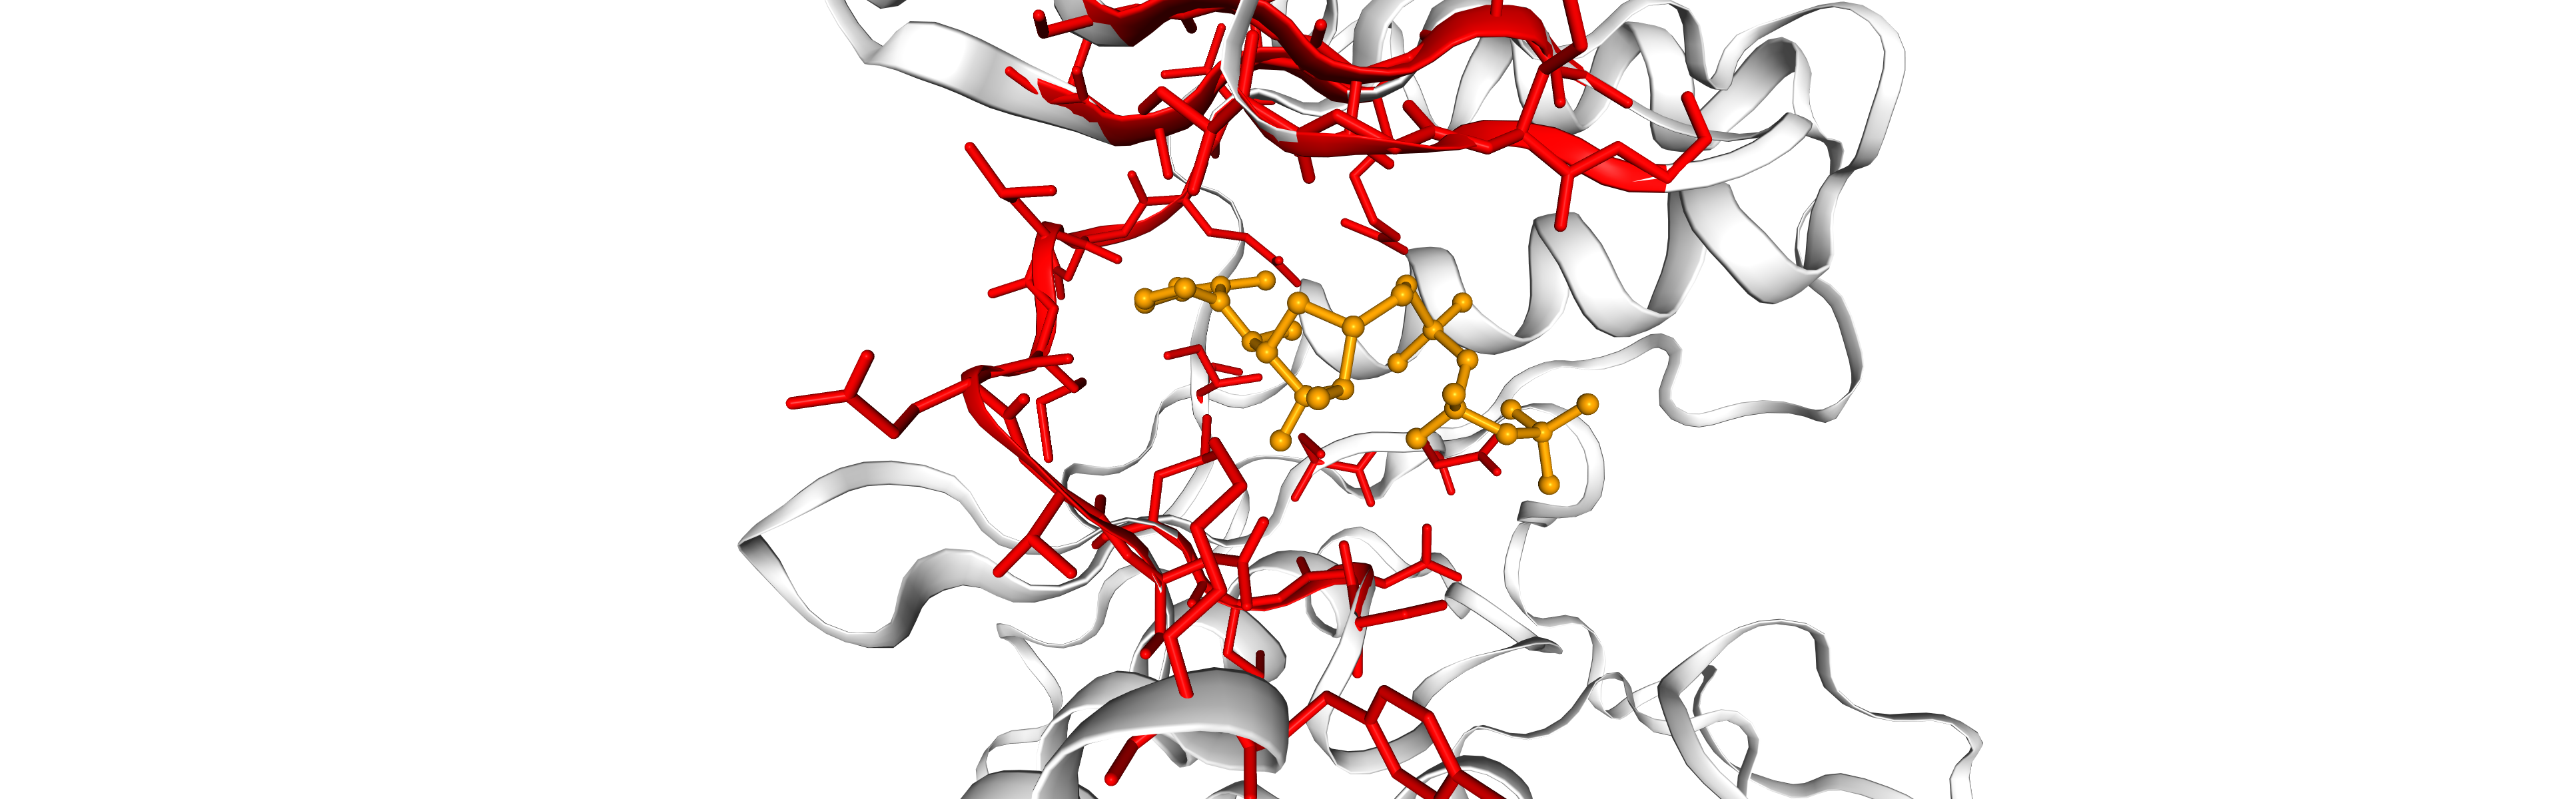

In [19]:
view._display_image()

#### NOTA:
Tomar en cuenta que es necesario un análisis a fondo de los ligandos. Como en este caso, el pdb id **1gol** posee como ligando al ATP. Sin embargo, hay un error en los anillos de la purina que deberá ser corregido o considerado en posteriores análisis.

## Determinación de los ligandos
Ahora, procedemos a utilizar la estructura de referencia modelada con *Modeller*. Hay que recordar que todas las estructuras modeladas fueron alineadas previamente tomando en cuenta la estructura secundaria de la proteína, y que el alineamiento incluyó la reposición relativa de los ligandos.

In [21]:
ref_strc_file = F'../../ARCHIVOS/CRISTALES/PROT_{prot_name.upper()}_PREPARADAS/PREP_ALL_ENSAMBLE/{pdbid_ref_name}_ENS.pdb'
ref_structure = parsePDB(ref_strc_file)

@> 5830 atoms and 1 coordinate set(s) were parsed in 0.20s.


Ahora calculamos el centro de *pocket*, que en realidad es el centro geométrico definido por los carbonos alfa de la lista de residuos `residues_list`.

In [22]:
# Cálculo del centro total de la proteína de referencia
centro_strc_total = calcCenter(ref_structure).round(3)

# Definimos los átomos del pocket
pocket = ref_structure.select("resnum " + residues_list_str)
pocket_center = calcCenter(pocket)

# Solo para comparar:
print("Centro de la estructura completa:", centro_strc_total)
print("Centro considerando todos los átomos de los residuos del pocket:", pocket_center)

Centro de la estructura completa: [58.56  25.207  7.139]
Centro considerando todos los átomos de los residuos del pocket: [52.66540795 36.61452929 11.42405439]


### Visualizamos
Cualquier molécula que tenga un átomo en contacto con la esfera, será considerada como ligando unido al sitio activo.

In [23]:
view_2 = nv.show_prody(ref_structure)
view_2.shape.add_sphere( pocket_center.tolist(), [0, 0, 0], 3)
view_2.add_licorice(selection = pocket.getIndices(), color='magenta')
view_2

NGLWidget()

In [24]:
view_2.render_image()

Image(value=b'', width='99%')

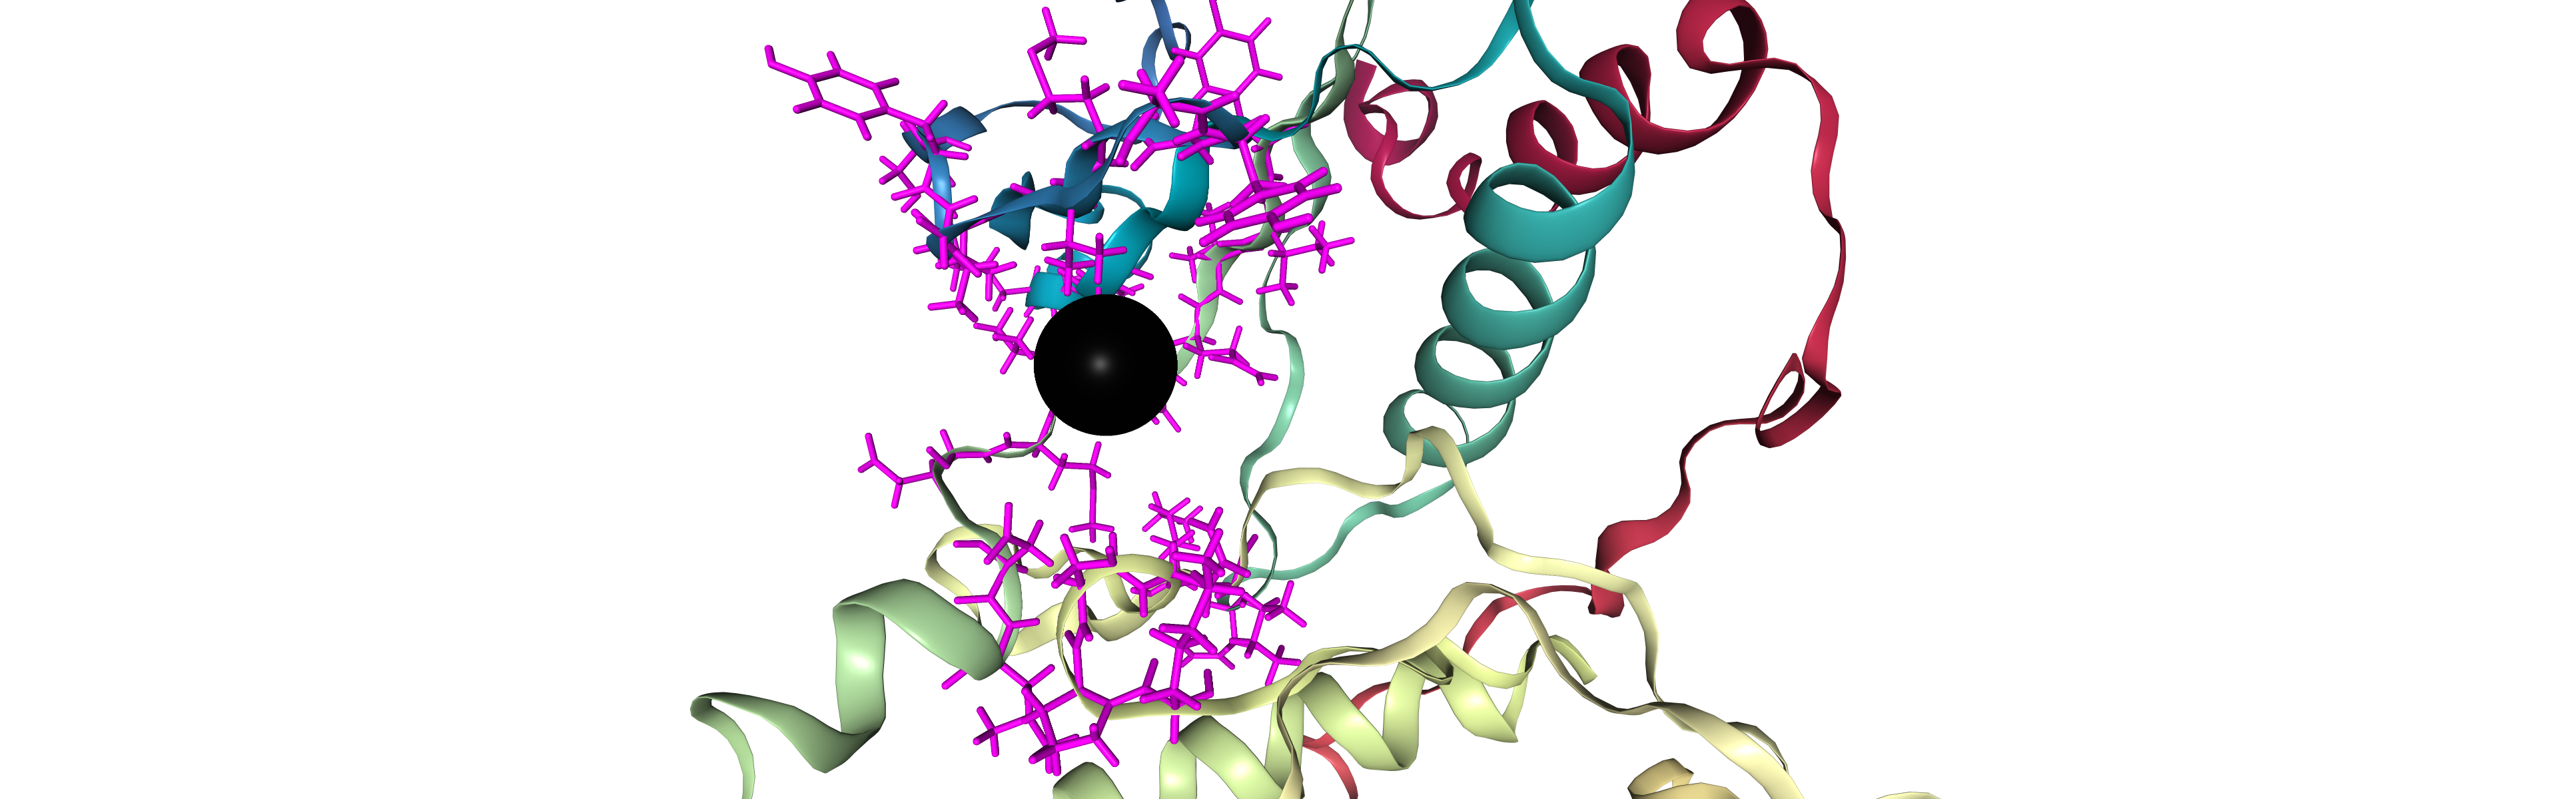

In [25]:
view_2._display_image()

### Pasos y función para obtener los ligandos

In [26]:
# Definimos los directorios de trabajo
RAW_LIG_DIR = F'../../ARCHIVOS/CRISTALES/LIGS_{prot_name.upper()}/RAW/'
PROT_CHAINS_DIR = F'../../ARCHIVOS/CRISTALES/PROT_{prot_name.upper()}_PREPARADAS/PREP_ALL_ENSAMBLE/'

# Directorio de salida (lo creamos si no existe):
PK_LIGS_DIR = F'../../ARCHIVOS/CRISTALES/LIGS_{prot_name.upper()}/POCKET_LIGS/'
import os
if not os.path.exists(PK_LIGS_DIR):
    os.makedirs(PK_LIGS_DIR)

In [27]:
def get_pocket_ligand(pdb_id,
                       pocket_residues = residues_list_str,
                       cutoff = 3,
                       raw_lig_dir = RAW_LIG_DIR,
                       prot_chain_dir = PROT_CHAINS_DIR,
                       pk_ligs_dir = PK_LIGS_DIR,
                       min_weight = 97, # mw de sulfato  + 1
                       write_files = True):
    # 1) Se carga cargan las moléculas HETATM usando Prody
    try:
        lig = parsePDB(raw_lig_dir + pdb_id  + "_lig.pdb")
    except Exception as e:
        print("La proteina", pdb_id, "NO TIENE LIGANDO.")
        return(None, None)
    # 2) Se carga la proteína y se seleccionan los residuos que definen el pocket
    protein = parsePDB( prot_chain_dir + pdb_id + "_ENS.pdb" )
    protein_pocket = protein.select("resid " + pocket_residues)
    
    # Se seleccionan los ligandos (RESIDUOS no protéicos) que estén a no más de cutoff A
    # de cualquier átomo de los residuos del pocket de la proteína
    lig_sel = lig.select('within ' + str(cutoff) + ' of inhibitor', inhibitor = protein_pocket)
    if lig_sel is None:
        print("La proteina", pdb_id, "no tiene ligando en el pocket.")
        return(None, None)
    
    # Se obtine la lista de moléculas que cumplen el criterio anterior
    inhibidor_list = np.unique( lig_sel.getResnums() )
    print( inhibidor_list )
    
    # Calcula el centro geométrico del pocket de la proteína
    prot_pocket_center = calcCenter(protein_pocket)
    
    # Puede que haya más de una molécula en el pocket 
    # (debido a presencia de iones, cosolvente o residuos modificados)
    # Se itera entre cada molecula del ligando, se calcula su masa y se mantiene el ligando con mayor masa 
    heavier_lig_mass = 0
    true_lig = ""

    for i in inhibidor_list:
            mol = lig.select("resnum " + str(i))
            mass = mol.getMasses().sum()
            # Se considera ligando sólo si su masa es igual o mayor a la de una molécula de sulfato
            if mass < min_weight:
                continue
            # Si las masas de dos moléculas son iguales, decide entre la molécula más cerana
            if mass == heavier_lig_mass :
                dist_prot_m1 = calcDistance(prot_pocket_center, calcCenter(mol))
                dist_prot_m2 = calcDistance(prot_pocket_center, calcCenter(true_lig))
                if dist_prot_m1 < dist_prot_m2:
                    heavier_lig_mass, true_lig = mass, mol
                    continue
            # Si el ligando i es más pesado que i - 1, se actualizan los datos
            heavier_lig_mass, true_lig = (mass, mol) if mass > heavier_lig_mass else (heavier_lig_mass, true_lig)
            
    # Se guarda el ligando sólo si su masa es igual o mayor a la de un sulfato
    # si el ligando aparece 2 veces cerca del pocket, se elige la molécula más cercana al centro
    if true_lig != "": # Si el ligando existe y su masa fue mayor 96
        # Se extrae el nombre del ligando
        name_lig = np.unique( true_lig.getResnames() )[0]

        # Se combinan proteína y ligando en un solo objeto AtomGroup, de tal manera que
        # sea posible superponer las estructuras de la proteína de acuerdo a los residuos de su pocket
        # y esto afcete la psoición del ligando
        complejo_PL = protein + true_lig.toAtomGroup()
        if write_files:
            # Se guardan ligando y proteína alineados según la estructura de referencia
            print(F'Proteína {pdb_id}: ligando {name_lig} guardado.')
            writePDB( pk_ligs_dir + "/" + pdb_id + "_" + name_lig + "_LIG.pdb", 
                      complejo_PL.select("resname " + name_lig) )
        return(name_lig, heavier_lig_mass)
    else: 
        print(F"La proteina {pdb_id} NO TIENE LIGANDO.")
        return(None, None)

### Obtenemos los ligandos y actualizamos el dataframe
Finalmente se obtienen los ligandos y a la tabla de datos se le agrega la información sobre el inhibidor y su masa

In [33]:
# Se agregan dos columnas al dataframe
df_prot["Inhib"] = ""
df_prot["Inhib_mass"] = np.nan

# Se obtienen los ligandos
for pdb_id in df_prot.index:
    inhibidor = get_pocket_ligand(pdb_id, write_files=True, cutoff=3, min_weight = 97)
    df_prot.at[str(pdb_id), 'Inhib'] = inhibidor[0]
    df_prot.at[pdb_id, 'Inhib_mass'] = inhibidor[1]

@> 111 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 42 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.


La proteina 1erk NO TIENE LIGANDO.
[513 537 581 582 704 819]
Proteína 1gol: ligando ATP guardado.
[1001]
Proteína 1pme: ligando SB2 guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1001]
Proteína 1tvo: ligando FRZ guardado.
[1001]
Proteína 1wzy: ligando F29 guardado.
La proteina 2erk NO TIENE LIGANDO.
La proteina 2fys NO TIENE LIGANDO.
La proteina 2gph NO TIENE LIGANDO.
[360]
Proteína 2ojg: ligando 19A guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.


[360]
Proteína 2oji: ligando 33A guardado.
[360]
Proteína 2ojj: ligando 82A guardado.
[1359]
Proteína 2y9q: ligando ANP guardado.


@> 45 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1001 2003]
Proteína 2z7l: ligando S91 guardado.
[1]
Proteína 3c9w: ligando HMY guardado.
[800]
Proteína 3erk: ligando SB4 guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 47 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 6 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 72 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401 402]
Proteína 3i5z: ligando Z48 guardado.
[401 404]
Proteína 3i60: ligando E86 guardado.
La proteina 3o71 no tiene ligando en el pocket.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 92 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 79 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.


[359 369]
Proteína 3qyw: ligando 6PB guardado.
[359 362 367]
Proteína 3qyz: ligando Z8B guardado.
La proteina 3r63 NO TIENE LIGANDO.
[161 166 361]
Proteína 3sa0: ligando NRA guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 5 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 3tei: ligando ANP guardado.
[401]
Proteína 3w55: ligando 1FM guardado.
La proteina 3zu7 NO TIENE LIGANDO.
[1359]
La proteina 3zuv NO TIENE LIGANDO.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 72 atoms and 1 coordinate set(s) were parsed in 0.00s.


[800]
Proteína 4erk: ligando OLO guardado.
[401]
Proteína 4fmq: ligando ANP guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 86 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 120 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 88 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401 403]
Proteína 4fux: ligando E75 guardado.
[159 164 401]
Proteína 4fuy: ligando EK2 guardado.
[164 401 402 410]
Proteína 4fv0: ligando EK3 guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 107 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 76 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.07s.


[401 402 407]
Proteína 4fv1: ligando EK4 guardado.
[401 404 406 410]
Proteína 4fv2: ligando EK5 guardado.
[401 405]
Proteína 4fv3: ligando EK6 guardado.


@> 74 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 91 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 76 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.07s.


[159 401 403]
Proteína 4fv4: ligando EK7 guardado.
[401 405]
Proteína 4fv5: ligando EK9 guardado.
[401 402]
Proteína 4fv6: ligando E57 guardado.


@> 117 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 88 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 79 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401 407]
Proteína 4fv7: ligando E94 guardado.
[401 402]
Proteína 4fv8: ligando E63 guardado.
[401 402]
Proteína 4fv9: ligando E71 guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 98 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.


[401 403]
Proteína 4g6n: ligando EK0 guardado.
[401 405]
Proteína 4g6o: ligando E28 guardado.
[406 408]
Proteína 4gsb: ligando PGE guardado.


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 43 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.


[159 402 403]
Proteína 4gt3: ligando ATP guardado.
[401]
Proteína 4gva: ligando ADP guardado.
[401]
Proteína 4h3p: ligando ANP guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 47 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 135 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 4h3q: ligando ANP guardado.
[401]
Proteína 4i5h: ligando G17 guardado.
[900]
Proteína 4iz5: ligando ADP guardado.
La proteina 4iz7 NO TIENE LIGANDO.
La proteina 4iza NO TIENE LIGANDO.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 42 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.


[166 401]
Proteína 4n0s: ligando DHC guardado.
[401]
Proteína 4n4s: ligando 2H1 guardado.
[401]
Proteína 4nif: ligando ANP guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 4o6e: ligando 2SH guardado.
[401]
Proteína 4qp1: ligando EMU guardado.
[401 402]
Proteína 4qp2: ligando 36R guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 4qp3: ligando 36Q guardado.
[401]
Proteína 4qp4: ligando 36O guardado.
[401 402]
Proteína 4qp6: ligando 36N guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 41 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 4qp7: ligando 363 guardado.
[401]
Proteína 4qp8: ligando 362 guardado.
[401]
Proteína 4qp9: ligando 35X guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 86 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 149 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 4qpa: ligando 35W guardado.
[405 407 411]
Proteína 4qta: ligando 38Z guardado.
[401 408 415 426 430]
Proteína 4qte: ligando 390 guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 37 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 4qyy: ligando 3G7 guardado.
La proteina 4s2z NO TIENE LIGANDO.
La proteina 4s30 NO TIENE LIGANDO.
La proteina 4s31 NO TIENE LIGANDO.
[401 403]
Proteína 4s32: ligando ANP guardado.
[401 403]
Proteína 4s33: ligando ANP guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 45 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 38 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


[402 403]
Proteína 4s34: ligando ANP guardado.
[401]
Proteína 4xj0: ligando 41B guardado.
[401]
Proteína 4xne: ligando TT4 guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 37 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


[164 401]
Proteína 4xoy: ligando CME guardado.
[401]
Proteína 4xoz: ligando 620 guardado.
[159 164 404]
Proteína 4xp0: ligando CME guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 80 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 47 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 4xp2: ligando TT4 guardado.
[401 404 406 412]
Proteína 4xp3: ligando DX4 guardado.
[401]
Proteína 4xrj: ligando 620 guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 86 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 37 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 40 atoms and 1 coordinate set(s) were parsed in 0.00s.


[402]
Proteína 4xrl: ligando 42A guardado.
[166 401]
Proteína 4zxt: ligando CME guardado.
[1357]
Proteína 4zzm: ligando CQ6 guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 41 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1355]
Proteína 4zzn: ligando CQ8 guardado.
[1357]
Proteína 4zzo: ligando CQ3 guardado.
[401]
Proteína 5ax3: ligando 5ID guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 5bue: ligando 4V8 guardado.
[402]
Proteína 5bui: ligando 4V9 guardado.
[401]
Proteína 5buj: ligando 4VB guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 114 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401 404]
Proteína 5bvd: ligando 4VF guardado.
[401]
Proteína 5bve: ligando 4VG guardado.
[401 406]
Proteína 5bvf: ligando 4VJ guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 103 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 39 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 70 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401 406]
Proteína 5hd4: ligando 38Z guardado.
[401]
Proteína 5hd7: ligando 38Z guardado.
[401]
Proteína 5k4i: ligando 6QB guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 95 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 89 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 5ke0: ligando 6S9 guardado.
[401]
Proteína 5lcj: ligando 6TS guardado.
[404 405]
Proteína 5lck: ligando 6TT guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 45 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 42 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 37 atoms and 1 coordinate set(s) were parsed in 0.00s.


[403]
Proteína 5ngu: ligando 8X2 guardado.
[402]
Proteína 5nhf: ligando 8X5 guardado.
[402 404]
Proteína 5nhh: ligando 8XH guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 38 atoms and 1 coordinate set(s) were parsed in 0.00s.


[402 403]
Proteína 5nhj: ligando 8XE guardado.
[402]
Proteína 5nhl: ligando 8XB guardado.
[402]
Proteína 5nho: ligando 8XN guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 5 atoms and 1 coordinate set(s) were parsed in 0.00s.


[403]
Proteína 5nhp: ligando 8XK guardado.
[402]
Proteína 5nhv: ligando 8QB guardado.
[401]
Proteína 5u6i: ligando 81Y guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.


La proteina 5umo no tiene ligando en el pocket.
[401 408]
Proteína 5v60: ligando ACP guardado.
La proteina 5v61 no tiene ligando en el pocket.
[406]


@> 86 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 93 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 102 atoms and 1 coordinate set(s) were parsed in 0.00s.


Proteína 5v62: ligando FRZ guardado.
[161 166 401]
Proteína 5wp1: ligando B7S guardado.
[403]
Proteína 6cpw: ligando F8V guardado.
La proteina 6d5y NO TIENE LIGANDO.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


[403]
Proteína 6dcg: ligando G67 guardado.
[404]
La proteina 6dmg NO TIENE LIGANDO.
[403 405]
Proteína 6fi3: ligando DJ2 guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 39 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 38 atoms and 1 coordinate set(s) were parsed in 0.00s.


[164 402 403]
Proteína 6fi6: ligando DF8 guardado.
[401 404 406]
Proteína 6fj0: ligando A3N guardado.
[402]
Proteína 6fjb: ligando AOC guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


[402]
Proteína 6fjz: ligando DKW guardado.
[402 403]
Proteína 6fle: ligando DQ2 guardado.
[403]
Proteína 6flv: ligando DTW guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.


[406]
Proteína 6fma: ligando DU8 guardado.
[401]
Proteína 6fn5: ligando DVZ guardado.
[402 403]
Proteína 6fq7: ligando E2K guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 96 atoms and 1 coordinate set(s) were parsed in 0.00s.


[408]
Proteína 6fr1: ligando E3K guardado.
[404 407]
Proteína 6frp: ligando ZAS guardado.
[405]
Proteína 6fxv: ligando E9W guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 46 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


[402 403 409 416]
Proteína 6g54: ligando 6H3 guardado.
[403 404]
Proteína 6g8x: ligando EQT guardado.
[403]
Proteína 6g91: ligando EQW guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 76 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 91 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 85 atoms and 1 coordinate set(s) were parsed in 0.00s.


[404]
Proteína 6g92: ligando ERZ guardado.
[406]
Proteína 6g93: ligando EU2 guardado.
[403 407]
Proteína 6g97: ligando EQZ guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 95 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 93 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 104 atoms and 1 coordinate set(s) were parsed in 0.00s.


[404]
Proteína 6g9a: ligando ESQ guardado.
[403 406]
Proteína 6g9d: ligando ER8 guardado.
[404 405]
Proteína 6g9h: ligando ERW guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 100 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 92 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 111 atoms and 1 coordinate set(s) were parsed in 0.00s.


[166 402 403]
Proteína 6g9j: ligando ERK guardado.
[402 404]
Proteína 6g9k: ligando ESK guardado.
[404]
Proteína 6g9m: ligando ESW guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 131 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 90 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.08s.


[402 407]
Proteína 6g9n: ligando ESN guardado.
[166 404]
Proteína 6gdm: ligando F3Z guardado.
[403 405 407]
Proteína 6gdq: ligando EVK guardado.


@> 110 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 116 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 174 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


[402 406]
Proteína 6ge0: ligando EVQ guardado.
[402 406]
Proteína 6gjb: ligando F0H guardado.
[402 405 406 411]
Proteína 6gjd: ligando F0E guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


La proteina 6nbs no tiene ligando en el pocket.
[401 403]
Proteína 6opg: ligando ANP guardado.
[401]
Proteína 6oph: ligando 6QB guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 5 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401]
Proteína 6opi: ligando N0V guardado.
[401]
Proteína 6opk: ligando 390 guardado.
La proteina 6ot6 no tiene ligando en el pocket.
La proteina 6ots NO TIENE LIGANDO.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 41 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 106 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.


[402]
La proteina 6q7k NO TIENE LIGANDO.
[402 403]
La proteina 6q7s NO TIENE LIGANDO.
[402 403]
La proteina 6q7t NO TIENE LIGANDO.


@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 39 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.


[403 406]
La proteina 6qa1 NO TIENE LIGANDO.
[402 403]
La proteina 6qa3 NO TIENE LIGANDO.
[403 405]
La proteina 6qa4 NO TIENE LIGANDO.
[404 405]
La proteina 6qag NO TIENE LIGANDO.


@> 43 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


[402]
La proteina 6qah NO TIENE LIGANDO.
[402 405]
Proteína 6qal: ligando HV2 guardado.
[405]
Proteína 6qaq: ligando HVQ guardado.


@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.


[402]
Proteína 6qaw: ligando HVE guardado.


### Dataframe actualizado
Como resultado las moléculas fueron guardadas con el id del **PDB** correspondiente y el nombre de la molécula. Además el DataFrame inicial ahora tendrá dos columnas más:
1. **Inhib:** Con el nombre de la molécula hayada en el sitio activo (código del PDB), si la hubo.
2. **Inhib_mass**: Con la masa del ligando.
    
Por último guardamos dicho DataFrame:

In [34]:
df_prot[['Resolution', 'Identity',
       'Coverage', 'NumGaps', 'GapLen', 'NumLigs', 'NameLigs',
       'Inhib', 'Inhib_mass']].head(20)

,Resolution,Identity,Coverage,NumGaps,GapLen,NumLigs,NameLigs,Inhib,Inhib_mass
PDB_ID,,,,,,,,,
1erk,2.30,355,99.166667,1,[3],0,[],None,NaN
1gol,2.80,354,99.166667,1,[3],2,"[ATP, MG]",ATP,398.0
1pme,2.00,354,92.500000,4,"[15, 3, 1, 8]",3,"[CME, SB2, SO4]",SB2,342.0
1tvo,2.50,360,97.222222,2,"[7, 3]",1,[FRZ],FRZ,314.0
1wzy,2.50,360,97.222222,2,"[7, 3]",1,[F29],F29,350.0
2erk,2.40,353,98.055556,1,[7],2,"[PTR, TPO]",None,NaN
2fys,2.50,355,93.888889,4,"[9, 8, 4, 1]",0,[],None,NaN
2gph,1.90,354,95.833333,2,"[11, 4]",0,[],None,NaN
2ojg,2.00,360,93.611111,3,"[18, 2, 3]",2,"[19A, SO4]",19A,264.0


In [35]:
# Número total de posibles ligandos en el pocket
df_prot["Inhib"].notnull().sum()

138

### Finalmente guardamos el nuevo DataFrame

In [32]:
n_confs = df_prot.shape[0]
df_prot.to_json(F'../data/TABLA_MTDATA_{prot_name.upper()}_{n_confs}_crys_LIGS_INFO.json')

# Terminado!